<h1><div align="center">RNN for Timeseries</div></h1>
<div align="center">Bruno Gonçalves</div>
<div align="center"><a href="http://www.bgoncalves.com/">www.bgoncalves.com</a></div>
<div align="center">@bgoncalves</div>
<!--h2 align="center", style="font-size=150%">Part I</h2-->

In [1]:
import numpy as np
np.random.seed(123)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
tf.set_random_seed(123)

import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU

from math import sqrt
import matplotlib.pyplot as plt


import watermark

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


Let's start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -p numpy,scipy,keras,matplotlib,sklearn,pandas

Tue Sep 11 2018 

CPython 3.5.2
IPython 6.1.0

numpy 1.14.2
scipy 1.1.0rc1
keras 2.1.2
matplotlib 2.2.2
sklearn 0.19.1
pandas 0.22.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


# Load dataset

GDP data from the Federal Reserve Bank [website https://fred.stlouisfed.org/series/GDP](https://fred.stlouisfed.org/series/GDP)

In [3]:
series = pd.read_csv('GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

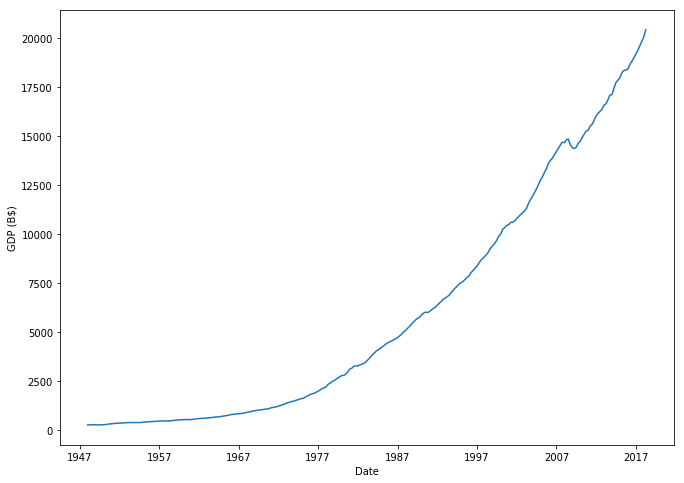

In [4]:
plt.plot(series)
plt.xlabel('Date')
plt.ylabel('GDP (B$)');
plt.gcf().set_size_inches(11,8)

You might remember the little "dip" around 2009.

## Scale the timeseries

The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues.

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
input_data = scaler.fit_transform(series)

In [9]:
series.head()

,GDP
DATE,
1948-01-01,265.742
1948-04-01,272.567
1948-07-01,279.196
1948-10-01,280.366
1949-01-01,275.034


## Training and Testing datasets 

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [10]:
n_points = input_data.shape[0]
train_points = int(2/3*n_points)+1

train, test = input_data[:train_points], input_data[train_points:]

the y values are just the next x value

In [11]:
X_train, X_test = train[:-1], test[:-1]
y_train, y_test = train[1:], test[1:]

print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 188 training points and 92 testing points


The SimpleRNN model expects a 3D dataset so we reshape them accordingly.

In [12]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(188, 1, 1)
(92, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model with 4 hidden units. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [17]:
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [18]:
nb_epoch = 20
batch_size = 1

history = model.fit(X_train, y_train, epochs=nb_epoch, verbose=1, batch_size=batch_size, shuffle=False)

Epoch 1/20
188/188 [==============================] - 1s 3ms/step - loss: 0.2175
Epoch 2/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 3/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 4/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0109
Epoch 5/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 6/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 7/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0061
Epoch 8/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 9/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 10/20
188/188 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 11/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 12/20
188/188 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13/20
188/188 [====

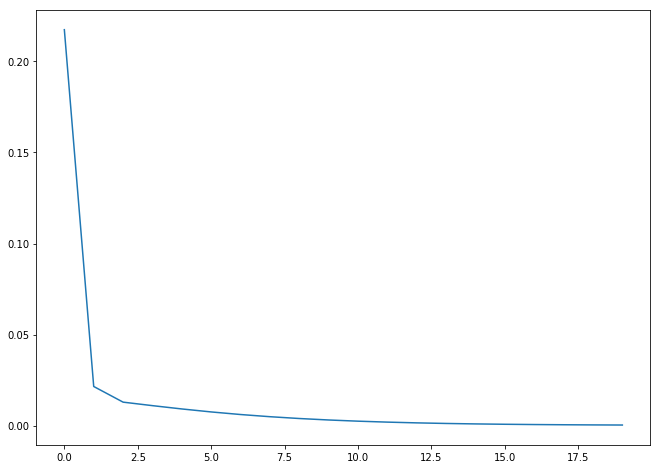

In [19]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

Make predictions using hte trained model

In [20]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Transform the predictions back to the original units

In [21]:
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

Transform the original data back to the original units

In [22]:
y_train_orig = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

Plot the predicted values. Don't forget to shift the test predictions to the right xx location

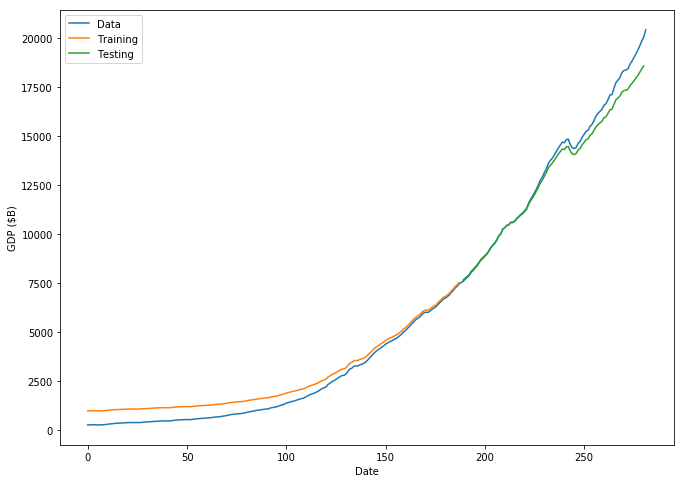

In [23]:
plt.plot(series.values, label='Data')
plt.plot(y_train_pred, label='Training')
plt.plot(len(y_train_pred)+1+np.arange(len(y_test_pred)), y_test_pred, label='Testing')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

Save the results for later

In [24]:
simple = np.concatenate([y_train_pred, y_test_pred])

# Multiple timesteps

So far we've been using just a SimpleRNN with just a single timestep. Now we'll see how we can use multiple timesteps (t-1, t) to predict the value at t+1. We'll keep the basic architecture of the system. We still have the raw data in memory, so we don't need to reload it. We just have to be careful when we build the inputs

In [28]:
X2_train, X2_test = np.concatenate([train[0:-3], train[1:-2], train[2:-1]], axis=1), np.concatenate([test[0:-3], test[1:-2], test[2:-1]], axis=1)
y2_train, y2_test = train[3:], test[3:]

print("We have", X2_train.shape[0], "training points and", X2_test.shape[0], "testing points")

We have 186 training points and 90 testing points


The more we increas the lag, the more points we lose! The rest of the code looks pretty much the same

In [29]:
tf.reset_default_graph()
keras.backend.clear_session()

X2_train = X2_train.reshape(X2_train.shape[0], X2_train.shape[1], 1)
X2_test = X2_test.reshape(X2_test.shape[0], X2_test.shape[1], 1)
print(X2_train.shape)
print(X2_test.shape)

(186, 3, 1)
(90, 3, 1)


But now we see that the result is slightly different. For each of our examples, we now have 3 timesteps to consider. Now we just need to refine the model:

In [30]:
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


Train it...

In [31]:
nb_epoch = 100
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/100
 - 1s - loss: 0.1389
Epoch 2/100
 - 0s - loss: 0.0097
Epoch 3/100
 - 0s - loss: 0.0051
Epoch 4/100
 - 0s - loss: 0.0025
Epoch 5/100
 - 0s - loss: 0.0014
Epoch 6/100
 - 0s - loss: 8.9823e-04
Epoch 7/100
 - 0s - loss: 6.3737e-04
Epoch 8/100
 - 0s - loss: 4.9134e-04
Epoch 9/100
 - 0s - loss: 4.0275e-04
Epoch 10/100
 - 0s - loss: 3.4561e-04
Epoch 11/100
 - 0s - loss: 3.0700e-04
Epoch 12/100
 - 0s - loss: 2.7997e-04
Epoch 13/100
 - 1s - loss: 2.6050e-04
Epoch 14/100
 - 1s - loss: 2.4609e-04
Epoch 15/100
 - 1s - loss: 2.3517e-04
Epoch 16/100
 - 1s - loss: 2.2667e-04
Epoch 17/100
 - 1s - loss: 2.1984e-04
Epoch 18/100
 - 1s - loss: 2.1411e-04
Epoch 19/100
 - 1s - loss: 2.0904e-04
Epoch 20/100
 - 1s - loss: 2.0431e-04
Epoch 21/100
 - 1s - loss: 1.9968e-04
Epoch 22/100
 - 1s - loss: 1.9502e-04
Epoch 23/100
 - 1s - loss: 1.9027e-04
Epoch 24/100
 - 1s - loss: 1.8538e-04
Epoch 25/100
 - 1s - loss: 1.8035e-04
Epoch 26/100
 - 1s - loss: 1.7523e-04
Epoch 27/100
 - 1s - loss: 1.7006e-04
Epo

And take a look at the results

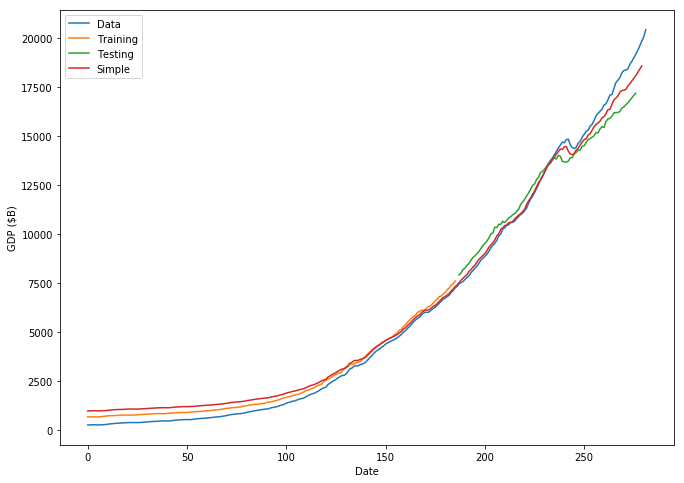

In [32]:
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

We've also included the previous result for ease of reference. Surprisingly, this new result is actually a bit worse. This is likely due to lack of training time

In [34]:
multiple = np.concatenate([y2_train_pred, y2_test_pred])

# LSTM

Let's see how an LSTM would behave in this situation. Now we have the advantage that everything else remains the same, and only the network architecture changes (slightly)

In [35]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=4, input_shape=(X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Naturally, we have many more parameters to train

In [36]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 2s - loss: 0.2831
Epoch 2/50
 - 1s - loss: 0.0103
Epoch 3/50
 - 1s - loss: 0.0065
Epoch 4/50
 - 1s - loss: 0.0055
Epoch 5/50
 - 1s - loss: 0.0045
Epoch 6/50
 - 2s - loss: 0.0036
Epoch 7/50
 - 2s - loss: 0.0029
Epoch 8/50
 - 2s - loss: 0.0022
Epoch 9/50
 - 2s - loss: 0.0017
Epoch 10/50
 - 2s - loss: 0.0013
Epoch 11/50
 - 2s - loss: 9.1928e-04
Epoch 12/50
 - 2s - loss: 6.4788e-04
Epoch 13/50
 - 2s - loss: 4.4119e-04
Epoch 14/50
 - 2s - loss: 2.8838e-04
Epoch 15/50
 - 2s - loss: 1.7949e-04
Epoch 16/50
 - 2s - loss: 1.0566e-04
Epoch 17/50
 - 2s - loss: 5.9271e-05
Epoch 18/50
 - 2s - loss: 3.3901e-05
Epoch 19/50
 - 2s - loss: 2.4106e-05
Epoch 20/50
 - 2s - loss: 2.5332e-05
Epoch 21/50
 - 2s - loss: 3.3831e-05
Epoch 22/50
 - 2s - loss: 4.6578e-05
Epoch 23/50
 - 2s - loss: 6.1252e-05
Epoch 24/50
 - 2s - loss: 7.6220e-05
Epoch 25/50
 - 2s - loss: 9.0467e-05
Epoch 26/50
 - 2s - loss: 1.0338e-04
Epoch 27/50
 - 2s - loss: 1.1455e-04
Epoch 28/50
 - 2s - loss: 1.2381e-04
Epoch 29/50
 

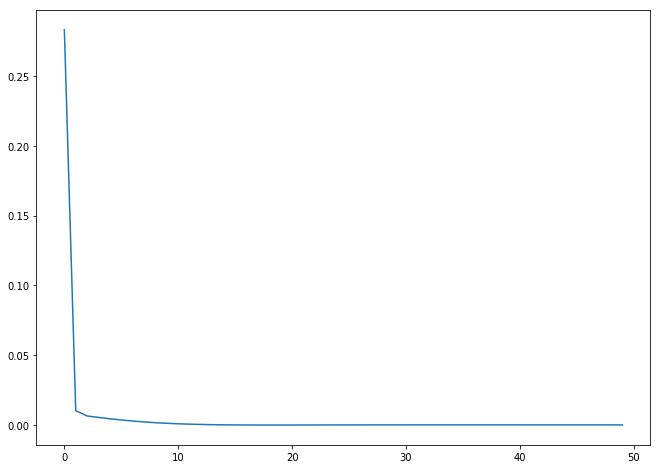

In [37]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

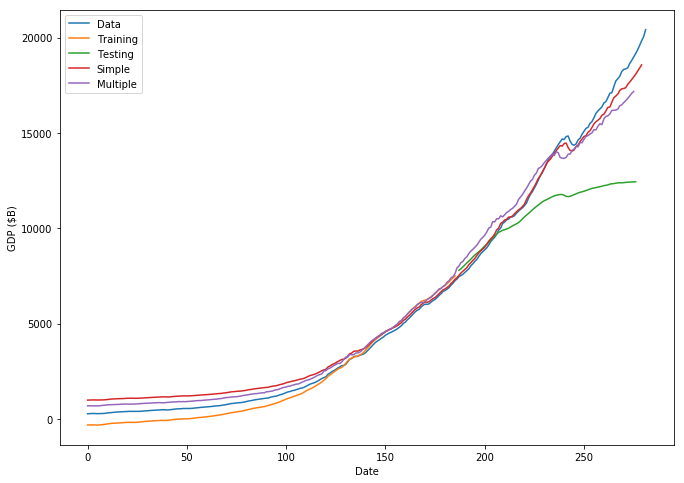

In [38]:
y2_train_pred = model.predict(X2_train)
y2_test_pred = model.predict(X2_test)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

lstm = np.concatenate([y2_train_pred, y2_test_pred])

## Stacked LSTM

In [39]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(LSTM(units=4, batch_input_shape=(1, X2_train.shape[1], X2_train.shape[2]), return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 3, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [40]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 3s - loss: 0.3492
Epoch 2/50
 - 1s - loss: 0.0192
Epoch 3/50
 - 1s - loss: 0.0157
Epoch 4/50
 - 2s - loss: 0.0134
Epoch 5/50
 - 2s - loss: 0.0112
Epoch 6/50
 - 2s - loss: 0.0093
Epoch 7/50
 - 2s - loss: 0.0075
Epoch 8/50
 - 2s - loss: 0.0060
Epoch 9/50
 - 2s - loss: 0.0047
Epoch 10/50
 - 2s - loss: 0.0036
Epoch 11/50
 - 2s - loss: 0.0027
Epoch 12/50
 - 2s - loss: 0.0019
Epoch 13/50
 - 2s - loss: 0.0013
Epoch 14/50
 - 3s - loss: 8.9956e-04
Epoch 15/50
 - 2s - loss: 5.7471e-04
Epoch 16/50
 - 2s - loss: 3.4651e-04
Epoch 17/50
 - 2s - loss: 1.9505e-04
Epoch 18/50
 - 2s - loss: 1.0209e-04
Epoch 19/50
 - 2s - loss: 5.1510e-05
Epoch 20/50
 - 2s - loss: 2.9829e-05
Epoch 21/50
 - 2s - loss: 2.6247e-05
Epoch 22/50
 - 3s - loss: 3.2680e-05
Epoch 23/50
 - 3s - loss: 4.3663e-05
Epoch 24/50
 - 2s - loss: 5.5762e-05
Epoch 25/50
 - 3s - loss: 6.6834e-05
Epoch 26/50
 - 3s - loss: 7.5808e-05
Epoch 27/50
 - 3s - loss: 8.2537e-05
Epoch 28/50
 - 2s - loss: 8.7436e-05
Epoch 29/50
 - 2s - loss:

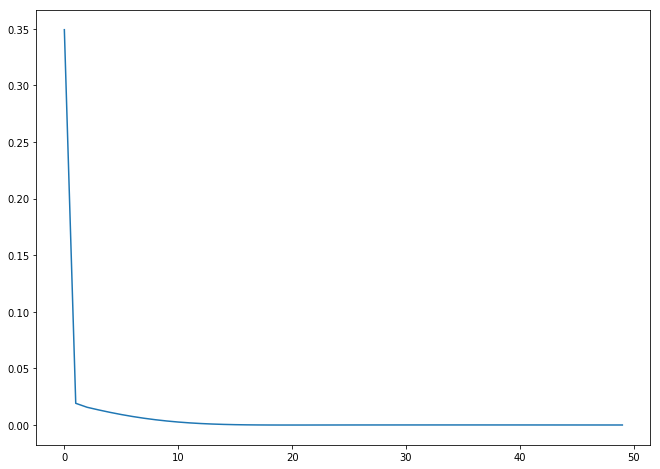

In [41]:
plt.plot(history.epoch, history.history['loss'])
plt.gcf().set_size_inches(11,8)

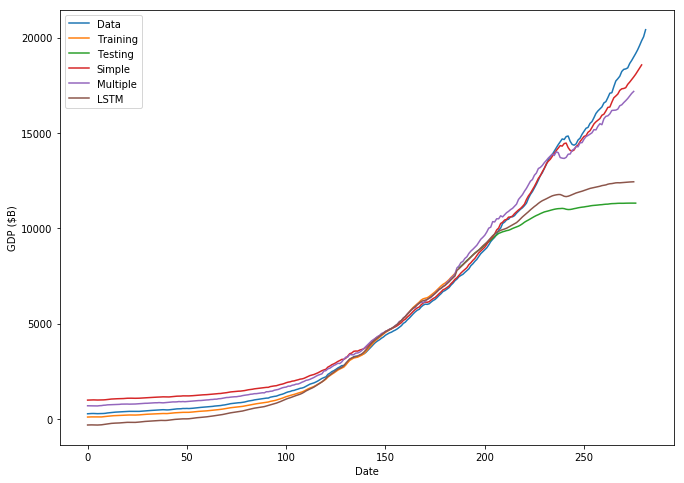

In [42]:
y2_train_pred = model.predict(X2_train, batch_size=1)
y2_test_pred = model.predict(X2_test, batch_size=1)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.plot(lstm, label='LSTM')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)

stacked = np.concatenate([y2_train_pred, y2_test_pred])

# GRU

In [44]:
tf.reset_default_graph()
keras.backend.clear_session()

model = Sequential()
model.add(GRU(units=4, batch_input_shape=(1, X2_train.shape[1], X2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 4)                    72        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [45]:
nb_epoch = 50
batch_size = 1

history = model.fit(X2_train, y2_train, epochs=nb_epoch, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 2s - loss: 0.5010
Epoch 2/50
 - 1s - loss: 0.0622
Epoch 3/50
 - 1s - loss: 0.0215
Epoch 4/50
 - 1s - loss: 0.0188
Epoch 5/50
 - 1s - loss: 0.0162
Epoch 6/50
 - 1s - loss: 0.0137
Epoch 7/50
 - 1s - loss: 0.0113
Epoch 8/50
 - 1s - loss: 0.0092
Epoch 9/50
 - 1s - loss: 0.0073
Epoch 10/50
 - 1s - loss: 0.0056
Epoch 11/50
 - 1s - loss: 0.0043
Epoch 12/50
 - 1s - loss: 0.0031
Epoch 13/50
 - 1s - loss: 0.0022
Epoch 14/50
 - 1s - loss: 0.0016
Epoch 15/50
 - 1s - loss: 0.0011
Epoch 16/50
 - 1s - loss: 7.3773e-04
Epoch 17/50
 - 1s - loss: 4.9714e-04
Epoch 18/50
 - 1s - loss: 3.3508e-04
Epoch 19/50
 - 1s - loss: 2.2782e-04
Epoch 20/50
 - 1s - loss: 1.5762e-04
Epoch 21/50
 - 1s - loss: 1.1187e-04
Epoch 22/50
 - 1s - loss: 8.1984e-05
Epoch 23/50
 - 1s - loss: 6.2275e-05
Epoch 24/50
 - 1s - loss: 4.9105e-05
Epoch 25/50
 - 1s - loss: 4.0167e-05
Epoch 26/50
 - 1s - loss: 3.3994e-05
Epoch 27/50
 - 1s - loss: 2.9641e-05
Epoch 28/50
 - 1s - loss: 2.6495e-05
Epoch 29/50
 - 1s - loss: 2.4163e

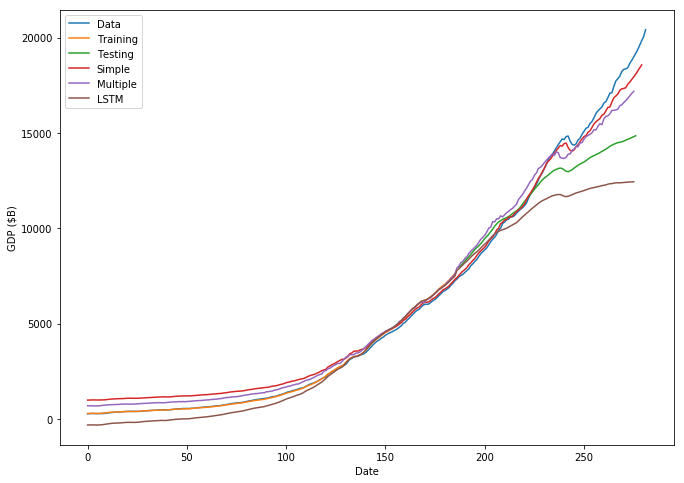

In [47]:
y2_train_pred = model.predict(X2_train, batch_size=1)
y2_test_pred = model.predict(X2_test, batch_size=1)

y2_train_pred = scaler.inverse_transform(y2_train_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)

y2_train_orig = scaler.inverse_transform(y2_train.reshape(-1,1))
y2_test_orig = scaler.inverse_transform(y2_test.reshape(-1,1))

plt.plot(series.values, label='Data')
plt.plot(y2_train_pred, label='Training')
plt.plot(len(y2_train_pred)+1+np.arange(len(y2_test_pred)), y2_test_pred, label='Testing')
plt.plot(simple, label='Simple')
plt.plot(multiple, label='Multiple')
plt.plot(lstm, label='LSTM')
plt.xlabel('Date')
plt.ylabel('GDP ($B)')
plt.legend()
plt.gcf().set_size_inches(11,8)